<img src="evry.jpg"
     width="400"
     height="151">

- TP DE MACHINE LEARNING / TEXT MINING
  
  
- MORALES KATHERINE


- M1 MINT UPS-SITE EVRY




<center>
    
#  Analiser le jeu de données complet  IMDB


</center>
    
## Le plan de travail est le suivant:

   [1. Analyse Descriptive](#1)
   
   [2. Modèlisation](#2)
   
   [2.1 Naive Bayes](#3)
   
   [2.2 M. Logistique](#4)
  
   
   
- Les packages nécessaires:   

In [23]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd

import nltk    #Natural language processing tool-kit
nltk.download('stopwords')
  
from nltk.corpus import stopwords                   #Stopwords corpus

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from keras.datasets import imdb
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Les fonctions:
 - **most_frequent_words**:  Fonction de la classe

In [24]:
def most_frequent_words(count_vect,data):    
    data_counts = count_vect.fit_transform(data)
    dictionary   = count_vect.get_feature_names()
    print("Taille du dictionnaire : ",len(dictionary))
    word_counts = pd.DataFrame(data_counts.toarray(),columns = dictionary)
    word_total_counts = pd.DataFrame()
    word_total_counts['count'] = word_counts.sum(axis=0)
    word_total_counts['word'] = dictionary
    word_total_counts_sorted_top  = word_total_counts.sort_values(by="count",ascending = False).iloc[0:20]
    plt.figure(figsize=(15,8))
    sns.barplot(x = word_total_counts_sorted_top.index,y=word_total_counts_sorted_top['count'])
    plt.xticks(rotation=90,fontsize=10)
    plt.show()
    return {'data_counts' : data_counts, 'word_total_counts' :word_total_counts, 'dictionary' : dictionary}

 - **getKeysByValue**:  Fonction créée en classe pour reconstruire les opinions en texte

In [25]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    print(listOfKeys)

 - **decoded**: Fonction pour obtenir la data  avec texte et être capable d'extraire les *stop words*

In [26]:
def decoded(X_train):
    X_train_cd=[]
    for k in range(0,len(X_train)):
        decoded = ' '.join([word_num_2.get(i - 3 , '.') for i in X_train[k]])
        X_train_cd.append(decoded)  
    return {'X_train_cd' : X_train_cd}  

 - **graf**: Fonction permettant de représenter graphiquement les réponses.

In [27]:
def graf(x,xfreq,title,ylabel,couleur,ylim):
    width = 0.8
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, xfreq, width, color=couleur)
    ax.set_ylim(0,ylim)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show() 

<a id="1"></a> 
 
# 1. Analyse Descriptive

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

In [ ]:
from keras.datasets import imdb
(X_train, Y_train), (X_test, Y_test) = imdb.load_data()

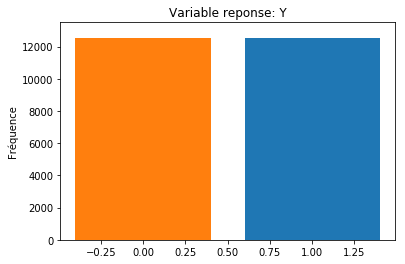

In [29]:
from matplotlib import colors as mcolors
import collections
c2=collections.Counter(Y_train)
colors = dict(mcolors.TABLEAU_COLORS)
graf(c2.keys(),c2.values(),'Variable reponse: Y','Fréquence',\
     colors,13500)

### Hashing

Le nombre de mots distincts peut être très grand surtout si la source des textes est bruitée (faute d’orthographe, spams, …). Pour réduire le nombre de mots, on peut utiliser un hash à valeur dans un ensemble plus petit que le nombre de mots découverts : c’est une sorte de modulo. Deux mots pourront être comptabilisés dans la même colonne. On utilise la classe 

On va garder les **stop words** de l'anglais, on a 179 mots.

In [31]:
stop = set(stopwords.words('english')) 
print(len(stop))
print(stop)

179
{'yours', 'i', 'needn', 'have', 'don', 'isn', 'd', 'theirs', "aren't", 'then', 'own', 'through', 'because', 'their', 'me', 'mustn', 'm', "it's", 'below', 'am', 'be', 'most', 'against', 'was', 'down', 'off', 're', 'now', 'once', 've', "you've", "hadn't", 'any', 'couldn', 'has', 'were', 'our', "shouldn't", 'whom', 'haven', 'hers', "mustn't", 'here', 'himself', 'itself', 'having', "isn't", 'did', 'and', 'there', 'but', "you'd", 'll', 'or', 'during', 'no', 'at', 'shan', 'in', 'of', 'with', 'all', 'other', "mightn't", 'its', 'by', 'hadn', 'his', 'just', 'ain', 'more', "doesn't", 'the', 'it', "hasn't", "should've", 'to', "couldn't", 'myself', 'further', "you'll", 'these', 'does', 'too', 'him', 'some', 'they', 'o', "don't", 'do', 'which', 't', 'where', 'not', 'your', 'who', 'what', 'both', 'wasn', 'yourselves', "that'll", "won't", 'weren', 'over', 'above', 'are', 'ma', 'them', 'again', "needn't", 'ourselves', "she's", "haven't", 'this', 'after', 'doesn', 'when', 'under', 'didn', 'if', 'un

On a le mot index utilisé dans cet jeu de données, où on peut voir chaque mot avec son identifiant numérique:

In [32]:
#word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
#import pickle
#with open('word_index', 'rb') as handle:
#    word_index=pickle.load(handle)
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [11]:
len(word_index)

88584

On réalise un exemple de reconstruction de l'opinion du premier individu, la première reconstruction ayant un format de liste, on changera la manière de stocker les informations textuelles.

In [12]:
# We decode the review, note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
for word_num in X_train[0]:
    getKeysByValue(word_index,word_num-3)

[]
['this']
['film']
['was']
['just']
['brilliant']
['casting']
['location']
['scenery']
['story']
['direction']
["everyone's"]
['really']
['suited']
['the']
['part']
['they']
['played']
['and']
['you']
['could']
['just']
['imagine']
['being']
['there']
['robert']
["redford's"]
['is']
['an']
['amazing']
['actor']
['and']
['now']
['the']
['same']
['being']
['director']
["norman's"]
['father']
['came']
['from']
['the']
['same']
['scottish']
['island']
['as']
['myself']
['so']
['i']
['loved']
['the']
['fact']
['there']
['was']
['a']
['real']
['connection']
['with']
['this']
['film']
['the']
['witty']
['remarks']
['throughout']
['the']
['film']
['were']
['great']
['it']
['was']
['just']
['brilliant']
['so']
['much']
['that']
['i']
['bought']
['the']
['film']
['as']
['soon']
['as']
['it']
['was']
['released']
['for']
['retail']
['and']
['would']
['recommend']
['it']
['to']
['everyone']
['to']
['watch']
['and']
['the']
['fly']
['fishing']
['was']
['amazing']
['really']
['cried']
['at']
['the

La deuxième façon est:

In [33]:
word_num_2 = dict([(value, key) for (key, value) in word_index.items()])
decoded = ' '.join([word_num_2.get(i - 3 , '.') for i in X_train[0]])
decoded

". this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should b

Les mots les plus fréquents dans le premier avis sont:

In [14]:
frequents_words=set()
for word_num in np.arange(20):
    frequents_words.add(getKeysByValue(word_index,word_num))

[]
['the']
['and']
['a']
['of']
['to']
['is']
['br']
['in']
['it']
['i']
['this']
['that']
['was']
['as']
['for']
['with']
['movie']
['but']
['film']


On va garder les données déchiffrées de X_train, on a fait un test avec les 5 premières observations.

In [15]:
X_train_cd=[]
for k in range(0,5):
    decoded = ' '.join([word_num_2.get(i - 3 , '.') for i in X_train[k]])
    X_train_cd.append(decoded)   
X_train_cd

[". this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should 

In [ ]:
text = X_train[0]
from os import path 
from scipy.misc import imread 
import matplotlib.pyplot as plt 
import random 
from wordcloud import WordCloud, STOPWORDS 
def generate_wordcloud(text): 
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 1.0,
                          stopwords = {'to', 'of'}
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
generate_wordcloud(text)

Ensuite, on changera toutes les données:


In [34]:
X_train_cd=[]
for k in range(0,len(X_train)):
    decoded = ' '.join([word_num_2.get(i - 3 , '.') for i in X_train[k]])
    X_train_cd.append(decoded) 
X_train_cd[1000]

". although i had seen gymkata in a theater way back in '85 i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of gymkata br br it turns out this is one of those films produced during the '80s that would go directly to video today the film stars champion gymnast kurt thomas as jonathan cabot recruited out of the blue to infiltrate the nation of parmistan to enter and hopefully win the game a suicidal bloodsport sponsored by the khan who encourages his people by yelling what sounds like yak power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess rubali who never speaks or leaves the house once trained tries to blend in with the locals by wearing a bright red sweater with dashes of bl

On fait la même procédure pour les données de test

In [17]:
X_test_cd=[]
for k in range(0,len(X_test)):
    decoded = ' '.join([word_num_2.get(i - 3 , '.') for i in X_test[k]])
    X_test_cd.append(decoded)   
#X_train_s = [' '.join(map(str, row)) for row in X_train]
#X_test_s = [' '.join(map(str, row)) for row in X_test]    
X_test_cd[0]

". please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

<a id="2"></a> 

# 2. Modélisation

On apprend le dictionnaire de vocabulaire et garde la matrice d'information

In [35]:
count_vect = CountVectorizer()
# Learn the vocabulary dictionary and return term-document matrix.
# CountVectorizer().fit_transform
X_sub_counts = count_vect.fit_transform(X_train_cd)
print(X_sub_counts)
print(X_sub_counts.shape)

  (0, 70353)	1
  (0, 59205)	1
  (0, 2024)	1
  (0, 38558)	1
  (0, 61491)	1
  (0, 68221)	1
  (0, 39460)	1
  (0, 19451)	1
  (0, 19473)	1
  (0, 51082)	1
  (0, 6233)	1
  (0, 59715)	1
  (0, 66321)	1
  (0, 9776)	1
  (0, 72768)	2
  (0, 51761)	1
  (0, 7155)	1
  (0, 63980)	1
  (0, 70192)	1
  (0, 28750)	1
  (0, 2565)	3
  (0, 66239)	1
  (0, 50180)	1
  (0, 62763)	1
  (0, 6358)	2
  :	:
  (24999, 44038)	1
  (24999, 44021)	1
  (24999, 6940)	1
  (24999, 5402)	2
  (24999, 19451)	1
  (24999, 9776)	3
  (24999, 7155)	1
  (24999, 46552)	5
  (24999, 72561)	1
  (24999, 72105)	1
  (24999, 66987)	4
  (24999, 34559)	5
  (24999, 61247)	1
  (24999, 4368)	2
  (24999, 26060)	1
  (24999, 3070)	1
  (24999, 34461)	5
  (24999, 66295)	1
  (24999, 3161)	6
  (24999, 66202)	10
  (24999, 53709)	1
  (24999, 35662)	1
  (24999, 72055)	1
  (24999, 24417)	2
  (24999, 66424)	2
(25000, 74702)


On  va créer le dictionnaire du jeu de données


In [19]:
dictionary=count_vect.get_feature_names()
print('\n Dans les donnes de X_train on a %d mots \n' %len(dictionary))
print(dictionary[16891])
print(count_vect.vocabulary_.get(u'decore'))


 Dans les donnes de X_train on a 74702 mots 

decore
16891


In [20]:
#toarray() we change all the matrix with the name of the columns 
#that we have in the dictionary 
word_counts = pd.DataFrame(X_sub_counts.toarray(),\
                           columns = dictionary)
word_counts.iloc[1:20,70470:70480]

,vacationers,vacationing,vacations,vaccaro,vaccarro,vaccination,vaccine,vaccum,vaccuum,vachon
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0


Les 20 mots les plus fréquents sont:

In [21]:
word_total_counts = pd.DataFrame()
word_total_counts['count'] = word_counts.sum(axis=0)
word_total_counts['word'] = dictionary
word_total_counts_sorted_top  = word_total_counts.sort_values(by="count"\
                                ,ascending = False).iloc[0:20]
print(word_total_counts_sorted_top)

        count   word
the    336758    the
and    164141    and
of     145865     of
to     135724     to
is     107336     is
br     101871     br
it      96471     it
in      93978     in
this    76007   this
that    73287   that
was     48209    was
as      46936     as
for     44345    for
with    44130   with
movie   44047  movie
but     42623    but
film    40161   film
you     34268    you
on      34203     on
not     30634    not


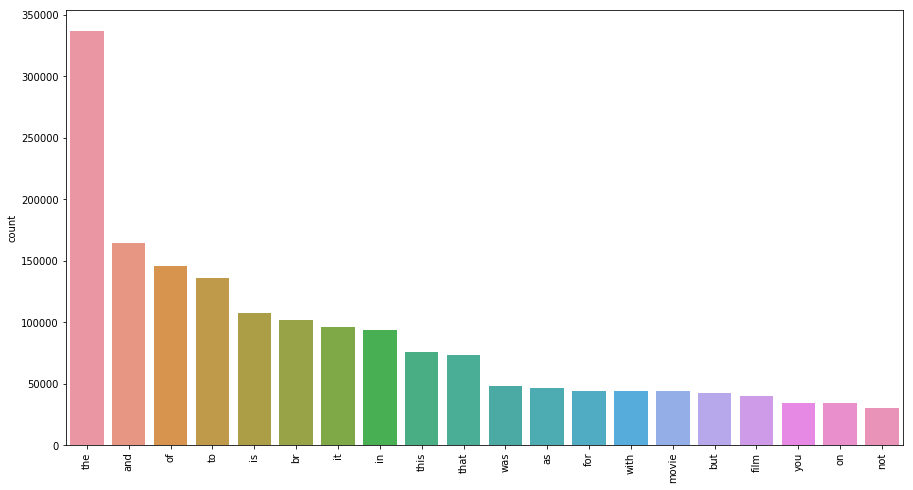

In [32]:
plt.figure(figsize=(15,8))
sns.barplot(x = word_total_counts_sorted_top.index,y=word_total_counts_sorted_top['count'])
plt.xticks(rotation=90,fontsize=10)
plt.show()

On a vu que les mots les plus fréquents font partie de l'ensemble des mots **stop words**, alors on va enlever ces mots. 

Taille du dictionnaire :  74557


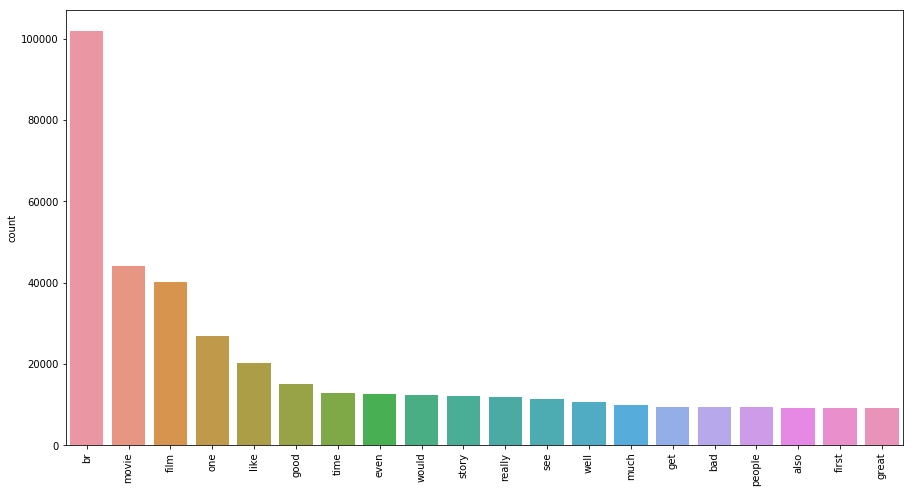

In [23]:
count_vect_sw = CountVectorizer(stop_words=stop)
most_frequent_words_sw = most_frequent_words(count_vect_sw,X_train_cd)

On a vu qu'il y a trois mots avec des fréquences élevées alors
on ajoute des mots plus communs aux mots **stop words**.

In [24]:
print(count_vect.vocabulary_.get(u'br'))
print(count_vect.vocabulary_.get(u'movie'))
print(count_vect.vocabulary_.get(u'film'))

8619
44021
24417


In [36]:
print(len(stop))
#stop.update({'br','film',movie'})
stop.add('movie')
stop.add('br')
stop.add('film')
stop.add('one')
print(len(stop))

179
183


Taille du dictionnaire :  74553


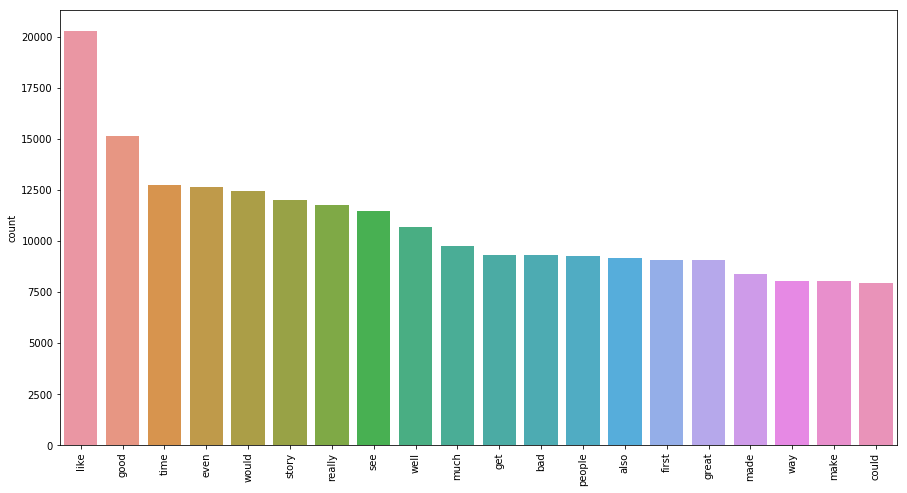

In [37]:
count_vect_sw = CountVectorizer(stop_words=stop)
most_frequent_words_sw2 = most_frequent_words(count_vect_sw,X_train_cd)

<a id="3"></a> 

## 2.1 Naive Bayes

On travaillera avec deux modèles dans chaque section:

- counts

In [27]:
NB_counts = MultinomialNB()
NB_modele=NB_counts.fit(X=most_frequent_words_sw2['data_counts'],y=Y_train)
accuracy_score(NB_modele.predict(most_frequent_words_sw2['data_counts']),Y_train)

0.91492

On a une précision de $91.49\%$ avec le modèle **Naive Bayes**, avec le *copus* (matrice des données).

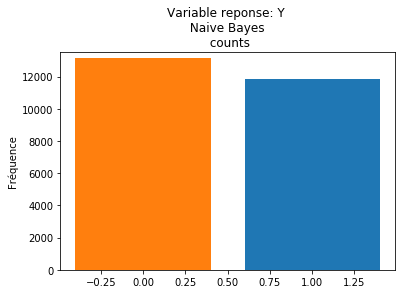

In [37]:
c2=collections.Counter(NB_modele.predict(most_frequent_words_sw2['data_counts']))
graf(c2.keys(),c2.values(),'Variable reponse: Y \n Naive Bayes \n counts','Fréquence',\
     colors,13500)

- tf idf


In [42]:
#Transform a count matrix to a normalized tf or tf-idf representation
#Tf means term-frequency while tf-idf means term-frequency times 
#inverse document-frequency. This is a common term weighting scheme 
#in information retrieval, that has also found good use in document 
#classification.
transformer = TfidfTransformer(smooth_idf=False)
tf_idf = transformer.fit_transform(most_frequent_words_sw2['data_counts'])

In [29]:
NB_modele_tfidf=NB_counts.fit(X=tf_idf.toarray(),y=Y_train)
accuracy_score(NB_modele_tfidf.predict(tf_idf.toarray()),Y_train)

0.91748

On a une précision de $91.74\%$ avec le modèle **Naive Bayes** avec la transformation tf-idf.

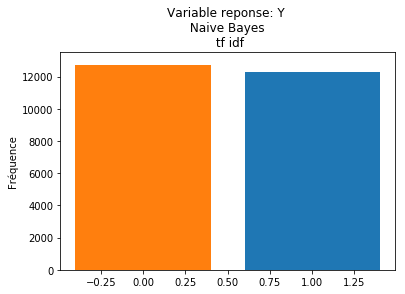

In [38]:
c2=collections.Counter(NB_modele_tfidf.predict(tf_idf.toarray()))
graf(c2.keys(),c2.values(),'Variable reponse: Y \n Naive Bayes \n tf idf','Fréquence',\
     colors,13500)

In [30]:
Data = pd.DataFrame()
Data['Sentence'] = X_train_cd
Data['Reponse'] = Y_train
Data['pred_counts_NB'] = NB_modele.predict(most_frequent_words_sw2['data_counts'])
Data['pred_tfidf_NB'] = NB_modele_tfidf.predict(tf_idf.toarray())
Data.head(5)

,Sentence,Reponse,pred_counts_NB,pred_tfidf_NB
0,. this film was just brilliant casting locatio...,1,1,1
1,. big hair big boobs bad music and a giant saf...,0,0,0
2,. this has to be one of the worst films of the...,0,0,0
3,. the scots excel at storytelling the traditio...,1,1,1
4,. worst mistake of my life br br i picked this...,0,0,0


<a id="4"></a> 

## 2.2 Modèle Logistique

Ensuite, on analyse le modèle logistique.


On dispose des informations suivantes sur la fonction utilisée pour créer le modèle logistique avec ses paramètres respectifs.


**Linear classifiers (SVM, logistic regression, a.o.) with SGD training**

 - loss : ‘hinge’, which gives a linear SVM. The ‘log’ loss gives logistic regression, a probabilistic classifier.
 - penalty: The penalty (aka regularization term) to be used. Defaults to ‘l2’ which is the standard regularizer for linear SVM models.
 - alpha : Constant that multiplies the regularization term. Defaults to 0.0001 Also used to compute learning_rate when set to ‘optimal’.
 - max_iter : The maximum number of passes over the training data (5df)

Alors, on a:

 - counts

In [38]:
mod_logistic = SGDClassifier(loss='hinge', penalty='l2',\
                           alpha=1e-3, random_state=42,\
                           max_iter=5, tol=None)
LOGISTIC_modele = mod_logistic.fit(most_frequent_words_sw2['data_counts'],Y_train)
accuracy_score(LOGISTIC_modele.predict(most_frequent_words_sw2['data_counts']),Y_train)

0.96196

In [39]:
print("On a  la mot la plus frequent pour la réponse (opinion) négatif est ", most_frequent_words_sw2['dictionary'][np.argsort(mod_logistic.coef_)[0][0]])
print("et pour la plus positif est ", most_frequent_words_sw2['dictionary'][np.argsort(mod_logistic.coef_)[0][-1]])

On a  la mot la plus frequent pour la réponse (opinion) négatif est  worst
et pour la plus positif est  superb


On a une précision de $96.19\%$ avec le modèle **Modèle Logistique**, avec la matrice des données.

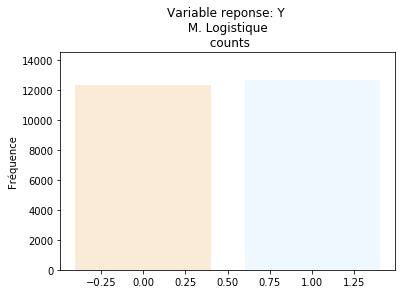

In [40]:
c2=collections.Counter(LOGISTIC_modele.predict(most_frequent_words_sw2['data_counts']))
colors = dict(mcolors.CSS4_COLORS)
graf(c2.keys(),c2.values(),'Variable reponse: Y \n M. Logistique \n counts','Fréquence',\
     colors,14500)

 - td idf

In [43]:
LOGISTIC_modele_tfidf = mod_logistic.fit(X=tf_idf.toarray(),y=Y_train)
accuracy_score(LOGISTIC_modele_tfidf.predict(tf_idf.toarray()),Y_train)

0.87388

On a une précision de $87.38\%$ avec le modèle **Modèle Logistique**, avec les données de la transformation tf idf.

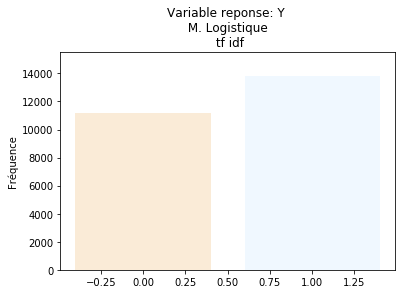

In [44]:
c2=collections.Counter(LOGISTIC_modele_tfidf.predict(tf_idf.toarray()))
graf(c2.keys(),c2.values(),'Variable reponse: Y \n M. Logistique \n tf idf','Fréquence',\
     colors,15500)

Résumé: 

In [33]:
Data['pred_counts_LOG'] = LOGISTIC_modele.predict(most_frequent_words_sw2['data_counts'])
Data['pred_tfidf_LOG'] = LOGISTIC_modele_tfidf.predict(tf_idf.toarray())
Data.head(5)

,Sentence,Reponse,pred_counts_NB,pred_tfidf_NB,pred_counts_LOG,pred_tfidf_LOG
0,. this film was just brilliant casting locatio...,1,1,1,1,1
1,. big hair big boobs bad music and a giant saf...,0,0,0,0,0
2,. this has to be one of the worst films of the...,0,0,0,0,0
3,. the scots excel at storytelling the traditio...,1,1,1,1,1
4,. worst mistake of my life br br i picked this...,0,0,0,0,0


Pour faire le modèle, elle utilise *Pipeline*

Construire un pipeline:

Bien que vous puissiez effectuer tous les traitements de manière séquentielle, la manière la plus élégante de construire un pipeline incluant tous les transformateurs et estimateurs. On va d'abord publier la définition du pipeline, puis des détails étape par étape.

                            vectorizer => transformer => classifier

In [45]:
from sklearn.pipeline import Pipeline
text_clf=Pipeline([('vect', CountVectorizer()),\
            ('tfidf',TfidfTransformer()),\
            ('clf', SGDClassifier(loss='hinge', penalty='l2',\
            alpha=1e-3, random_state=42,\
            max_iter=5, tol=None)),])

In [46]:
text_clf.fit(X_train_cd,Y_train)#
accuracy_score(text_clf.predict(X_train_cd),Y_train)

0.85772

On a une précision de $85.72\%$ avec **Pipeline**.

In [ ]:
Data['pred_pip'] = text_clf.predict(X_train_cd)

<a id="5"></a> 

# 3. Résultats

 - On a une meilleure précision avec le modèle Naive Bayes, pour la matrice de données de fréquence et pour la matrice avec la transformation tf idf, et la plus petite avec pilpeline.
